### Import required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from typing import Type, List
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, RandomApply, ColorJitter, RandomAffine, GaussianBlur, Grayscale, ToTensor, Normalize, RandomErasing, ElasticTransform

### Define BasicBlock

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

### ResNet model

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block: Type[BasicBlock], layers: List[int], num_classes: int = 10, img_channels: int = 3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Base transformation - Data Aug

In [ ]:
transform_svhn = Compose([
    RandomApply([ColorJitter(brightness=0.5, contrast=0.5)], p=0.3),
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052]),
])

transform_mnist = Compose([
    Resize((32,32)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])


### Loading Training and Test Sets

In [ ]:
train_dataset_svhn = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
test_dataset_svhn = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

train_loader_svhn = DataLoader(dataset=train_dataset_svhn, batch_size=16, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(dataset=test_dataset_svhn, batch_size=16, shuffle=False, num_workers=2)

train_dataset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=16, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders have been created.")

100%|██████████| 182040794/182040794 [00:15<00:00, 11440757.68it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 25337991.22it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 40677630.52it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118528076.15it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10105825.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8370179.60it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaders have been created.


### criterion - model - optimizer - loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10, img_channels=3 )
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Trainng

In [ ]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader_svhn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.8539
Epoch [2/10], Loss: 0.2644
Epoch [3/10], Loss: 0.2072
Epoch [4/10], Loss: 0.1685
Epoch [5/10], Loss: 0.1401
Epoch [6/10], Loss: 0.1150
Epoch [7/10], Loss: 0.0896
Epoch [8/10], Loss: 0.0703
Epoch [9/10], Loss: 0.0565
Epoch [10/10], Loss: 0.0404


### plotting the loss

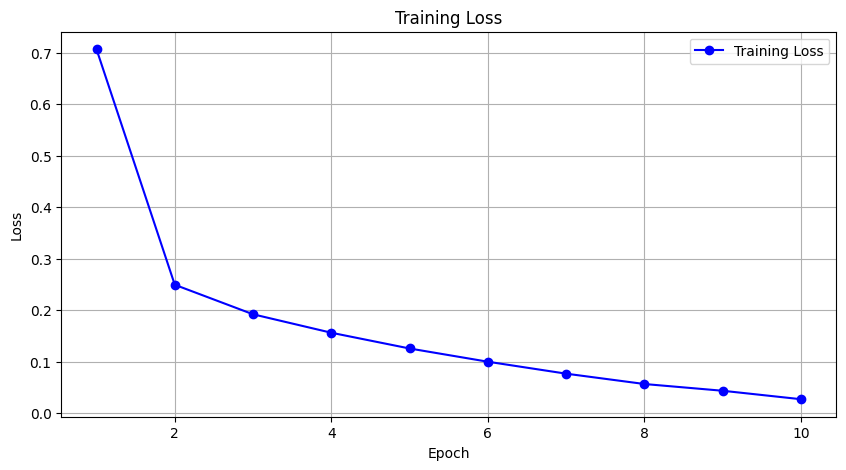

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

In [ ]:
accuracy_svhn = test_model(model, test_loader_svhn)
accuracy_mnist = test_model(model, test_loader_mnist)

Accuracy: 92.51%
Accuracy: 72.45%
